## Melissa Feeney
### 15 October 2022
### Lab 1 Option 1

1. Conduct a trend analysis of some variable of interest.  
2. Graph it and try different functional forms.  
3. Look for subgroup variation across time, too.  
4. Extra credit if you consider other variables as a means of explaining the trend.  
5. Explain all of your results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc = {'figure.figsize':(8,5)})
#sns.set_style('whitegrid')
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'whitegrid', rc = custom_params)
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth': 3})


**Variable Selection**
- The variable of interest that I selected from the GSS was "getahead". 
- The question associated with this variable in the GSS is "Some people say that people get ahead by their own hard work; others say that lucky breaks or help from other people are more important. Which do you think is most important?"

- The responses were on a 4-point scale, decoded as below:
    - 1 Hard work most important
    - 2 Hard work, luck equally important (so hard work is somewhat important in getting ahead)
    - 3 Luck most important
    - 4 Other


- For clarity, I reversed and recoded this variable in relation to the question, "how important do you think hard work is in getting ahead?" with respondents' scores decoded as:
    - 1 indicating that hard work is least important in getting ahead (and luck is most important in getting ahead)
    - 2 indicating that hard work is somewhat important in getting ahead (and luck is equally just as important)
    - 3 indicating that hard work is most important in getting ahead (and luck is least important in getting ahead)
    - *Responses of 4, along with missing values, were removed from the analysis*
    

In [2]:
# Read in data from the trends-gss.csv file from my local
gss = pd.read_csv("/Users/mfeene/Downloads/trends-gss.csv")

# Extract variables of interest- get ahead, education, attitude toward interview, gender
data = gss[['year', 'getahead', 'educ', 'coop', 'sex']]

data['getahead'].value_counts()


1.0    23022
2.0     7834
3.0     4085
4.0       36
Name: getahead, dtype: int64

In [3]:
# Remove NAs
data.dropna(inplace = True)

# Remove 4.0- they are a very small portion of the data but mess up the scale of the responses
data = data[(data['getahead'] != 4.0)]

data.head()

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,year,getahead,educ,coop,sex
1613,1973,2.0,6.0,1.0,1
1614,1973,1.0,8.0,2.0,2
1615,1973,1.0,11.0,1.0,2
1616,1973,1.0,12.0,1.0,1
1617,1973,1.0,8.0,1.0,2


In [4]:
# Recode variable to make it easier to work with 
# View the analysis through the lens of- how important is hard work in getting ahead?
# Recoded that 3 = hard work is most important, 1 = hard work is least important
data['getahead'] = data['getahead'].replace([1, 3], [3, 1])

def getahead_decode(row):
    if row['getahead'] == 3.0:
        decode = '3.0 Hard work most important, luck is least important'
    elif row['getahead'] == 2.0:
        decode = '2.0- Hard work and luck are equally important'  
    elif row['getahead'] == 1.0:
        decode = '1.0- Hard work is least important, luck is most important'   
    else:
        decode = 'mistake'
    return decode
   
data['getahead_category'] = data.apply(getahead_decode, axis = 1)


Text(0, 0.5, 'Response')

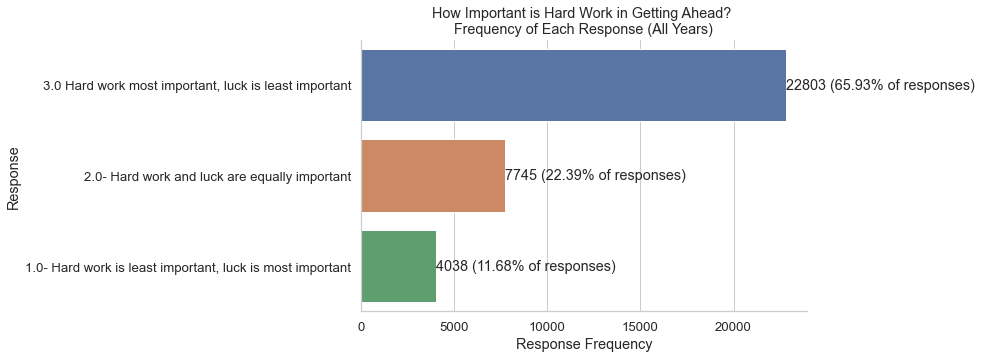

In [5]:
# Plot frequency distribution of responses
plot = sns.countplot(y = data['getahead_category'],
                     order = data['getahead_category'].value_counts(ascending = False).index)
        
abs_values = data['getahead_category'].value_counts(ascending = False)
rel_values = data['getahead_category'].value_counts(ascending = False, normalize = True).values * 100
lbls = [f'{p[0]} ({p[1]:.2f}% of responses)' for p in zip(abs_values, rel_values)]

plot.bar_label(container = plot.containers[0], labels = lbls)
plot.set(title = 'How Important is Hard Work in Getting Ahead? \nFrequency of Each Response (All Years)')
plot.set_xlabel('Response Frequency')
plot.set_ylabel('Response')


In [6]:
# Get the mean score per year
data['getahead'].mean()

2.5425605736425143

# 1. Graph Variable of Interest

[Text(0.5, 1.0, 'How Important is Hard Work in Getting Ahead?'),
 Text(0, 0.5, 'Mean Belief Score in Hard Work'),
 Text(0.5, 0, 'Year')]

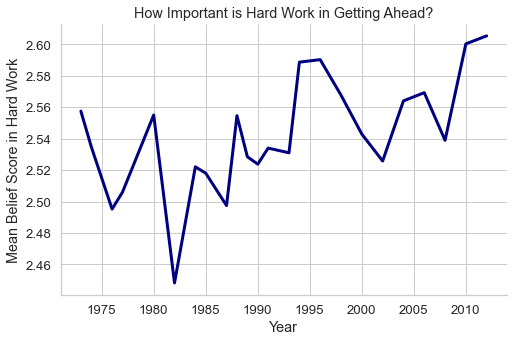

In [7]:
# By year, the average belief is still that hard work is most important in getting ahead
by_year = pd.DataFrame(data.groupby('year')['getahead'].mean()).reset_index()

by_year.columns = ['year', 'mean_getahead']

#sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth': 3})
by_year_plot = sns.lineplot(data = by_year, x = 'year', y = 'mean_getahead', color = 'navy')
by_year_plot.set(title = 'How Important is Hard Work in Getting Ahead?', 
                 ylabel = 'Mean Belief Score in Hard Work', xlabel = 'Year')


## Initial Findings
- **By year, the average belief is that hard work is most important in getting ahead.** 

- Recall the labeling system for the beliefs:
    - 3- Hard work is most important, luck is least important
    - 2- Hard work and luck are both equally important (hard work is somewhat important)
    - 1- Hard work is least important, luck is most important

- Since beliefs in whether or not hard work is most important in getting ahead were evaluated using a 3-point scale, mean values closer to 3 imply the belief that hard work is most important in getting ahead, and values closer to 1 imply hard work is least important in getting ahead. 
- The valley in the early/mid 1980s implies the lowest belief in hard work being most important in getting ahead. At this time, it can be presumed that many respondents felt that luck was an important part of getting ahead.
- The peak post-2010 implies the strongest belief in hard work being most important in getting ahead.
- As years pass, the overall belief that hard work is most important in getting ahead is strengthening, as the mean value grows closer to 3.


In [8]:
# Basic linear regression- super naive OLS
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit regression model
lm_getahead = smf.ols('getahead ~ year', data = data).fit()
lm_getahead.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     36.03
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.96e-09
Time:                        18:26:42   Log-Likelihood:                -36426.
No. Observations:               34586   AIC:                         7.286e+04
Df Residuals:                   34584   BIC:                         7.287e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3372      0.646     -2.069      0.039      -2.604      -0.070
year           0.0019      0.000      6.003      0.000       0.001       0.003
==============================================================================
Omnibus:                     5339.087   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8304.444
Skew:                          -1.200   Prob(JB):                         0.00
Kurtosis:                       3.062   Cond. No.                     3.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[Text(0.5, 1.0, 'How Important is Hard Work in Getting Ahead?'),
 Text(0, 0.5, 'Mean Belief Score in Hard Work'),
 Text(0.5, 0, 'Year')]

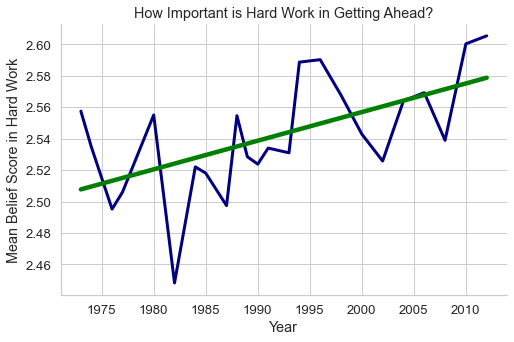

In [9]:
# However, adding a trend line to the line plot suggests that a linear fit does not capture some of the ups and downs
#sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth': 3})

# Original plot
by_year_plot = sns.lineplot(data = by_year, x = 'year', y = 'mean_getahead', color = 'navy')

# Add a linear trend line
sns.regplot(x = 'year', y = 'mean_getahead', data = by_year, scatter = False, ci = None, fit_reg = True, 
            color = 'green')
by_year_plot.set(title = 'How Important is Hard Work in Getting Ahead?', 
                 ylabel = 'Mean Belief Score in Hard Work', xlabel = 'Year')



## Naive OLS Findings
- **This regression model shows that as time passes (years increase), hard work is believed to become more important
to getting ahead.** 
    - Recall that in the variable encoding, 3 = hard work is most important, so increasing values imply that the belief that hard work is the most important is becoming more prevalent; that the value is increasing closer to 3. 
- The model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0019 points (on a 3-point scale), and is statistically significant at 95% confidence due to its low p-value (p-value less than 0.05, it is 0.000).
- The adjusted R-squared term is extremely low at 0.001, implying that we can explain about 0.1% of the variation in hard work being the most important thing in getting ahead by year. 
    - The linear trend line superimposed on the plot does not capture the peaks and valleys of the beliefs in a meaningful way. Therefore, the model's low adjusted R-squared score is not too surprising.

# 2. Try Different Functional Forms

## 2A. Creating dummy variables for the years

In [10]:
# Refit model using dummy variable for year- it is using 1973 as reference year
lm_getahead2 = smf.ols('getahead ~ C(year)', data = data).fit()
lm_getahead2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.479
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           4.44e-12
Time:                        18:26:43   Log-Likelihood:                -36392.
No. Observations:               34586   AIC:                         7.283e+04
Df Residuals:                   34562   BIC:                         7.304e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.5575      0.018    140.964      0.000       2.522       2.593
C(year)[T.1974]    -0.0226      0.026     -0.880      0.379      -0.073       0.028
C(year)[T.1976]    -0.0623      0.026     -2.431      0.015      -0.113      -0.012
C(year)[T.1977]    -0.0515      0.025     -2.022      0.043      -0.101      -0.002
C(year)[T.1980]    -0.0024      0.026     -0.095      0.925      -0.053       0.048
C(year)[T.1982]    -0.1093      0.024     -4.479      0.000      -0.157      -0.061
C(year)[T.1984]    -0.0354      0.026     -1.378      0.168      -0.086       0.015
C(year)[T.1985]    -0.0395      0.026     -1.547      0.122      -0.089       0.011
C(year)[T.1987]    -0.0601      0.024     -2.452      0.014      -0.108      -0.012
C(year)[T.1988]    -0.0029      0.029     -0.101      0.920      -0.059       0.054
C(year)[T.1989]    -0.0290      0.028     -1.019      0.308      -0.085       0.027
C(year)[T.1990]    -0.0337      0.029     -1.149      0.251      -0.091       0.024
C(year)[T.1991]    -0.0235      0.029     -0.819      0.413      -0.080       0.033
C(year)[T.1993]    -0.0265      0.028     -0.949      0.343      -0.081       0.028
C(year)[T.1994]     0.0312      0.024      1.300      0.194      -0.016       0.078
C(year)[T.1996]     0.0327      0.024      1.353      0.176      -0.015       0.080
C(year)[T.1998]     0.0102      0.024      0.417      0.676      -0.038       0.058
C(year)[T.2000]    -0.0146      0.024     -0.598      0.550      -0.062       0.033
C(year)[T.2002]    -0.0317      0.029     -1.084      0.278      -0.089       0.026
C(year)[T.2004]     0.0065      0.029      0.221      0.825      -0.051       0.064
C(year)[T.2006]     0.0117      0.023      0.522      0.602      -0.032       0.056
C(year)[T.2008]    -0.0186      0.026     -0.707      0.480      -0.070       0.033
C(year)[T.2010]     0.0428      0.027      1.605      0.108      -0.009       0.095
C(year)[T.2012]     0.0479      0.026      1.809      0.070      -0.004       0.100
==============================================================================
Omnibus:                     5315.170   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8251.723
Skew:                          -1.196   Prob(JB):                         0.00
Kurtosis:                       3.061   Cond. No.                         24.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# All the coefficient values before 1994 negative, after which there is a shift toward more positive coefficient values
# Use an F-test to see if 1982 (largest negative value pre-1994) is really statistically different 
# from 2012 (largest positive post-1994)
# very small p-value implies- statistically significant

hypothesis = '(C(year)[T.1982] = C(year)[T.2012])'
f_test = lm_getahead2.f_test(hypothesis)
print(f_test)


<F test: F=array([[38.76390806]]), p=4.837813601119384e-10, df_denom=3.46e+04, df_num=1>


## 2B. Adding a Quadratic term

[Text(0.5, 1.0, 'How Important is Hard Work in Getting Ahead?'),
 Text(0, 0.5, 'Mean Belief Score in Hard Work'),
 Text(0.5, 0, 'Year')]

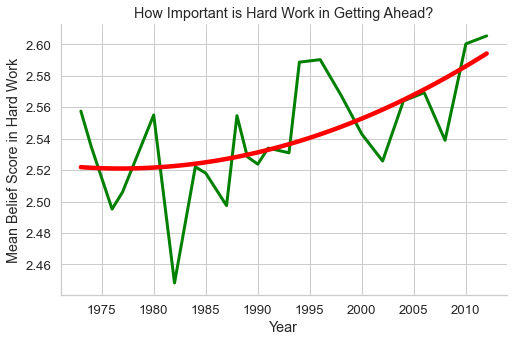

In [12]:
## Quadratic trend might work well here...

# Original plot
by_year_plot = sns.lineplot(data = by_year, x = 'year', y = 'mean_getahead', color = 'green')
by_year_plot.set(title = 'What is Most Important in Getting Ahead?', ylabel = 'Mean Belief Score in Hard Work', xlabel = 'Year')

# superimpose a quadratic fitted line using the seaborn package, specifying 'order = 2' for quadratic fit
sns.regplot(x = 'year', y = 'mean_getahead', data = by_year, order = 2, scatter = False, ci = None, 
            fit_reg = True, color = 'red')
by_year_plot.set(title = 'How Important is Hard Work in Getting Ahead?', 
                 ylabel = 'Mean Belief Score in Hard Work', xlabel = 'Year')


In [13]:
lm_getahead_qu = smf.ols('getahead ~ year + np.square(year)', data = data).fit()
lm_getahead_qu.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     19.42
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           3.72e-09
Time:                        18:26:43   Log-Likelihood:                -36424.
No. Observations:               34586   AIC:                         7.285e+04
Df Residuals:                   34583   BIC:                         7.288e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         197.6149    118.761      1.664      0.096     -35.160     430.389
year               -0.1978      0.119     -1.659      0.097      -0.432       0.036
np.square(year)  5.014e-05   2.99e-05      1.675      0.094   -8.52e-06       0.000
==============================================================================
Omnibus:                     5332.475   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8290.272
Skew:                          -1.199   Prob(JB):                         0.00
Kurtosis:                       3.059   Cond. No.                     1.26e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2C. Adding a Cubic term

[Text(0.5, 1.0, 'How Important is Hard Work in Getting Ahead?'),
 Text(0, 0.5, 'Mean Belief Score in Hard Work'),
 Text(0.5, 0, 'Year')]

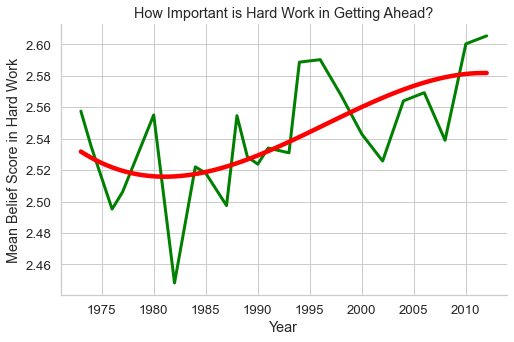

In [14]:
# Original plot
by_year_plot = sns.lineplot(data = by_year, x = 'year', y = 'mean_getahead', color = 'green')
by_year_plot.set(title = 'What is Most Important in Getting Ahead?', ylabel = 'Mean Belief Score in Hard Work', xlabel = 'Year')

# superimpose a cubic fitted line using the seaborn package, specifying 'order = 3' for cubic fit
sns.regplot(x = 'year', y = 'mean_getahead', data = by_year, order = 3, scatter = False, ci = None, 
            fit_reg = True, color = 'red')
by_year_plot.set(title = 'How Important is Hard Work in Getting Ahead?', 
                 ylabel = 'Mean Belief Score in Hard Work', xlabel = 'Year')


In [15]:
lm_getahead_cu = smf.ols('getahead ~ year + np.square(year) + np.power(year, 3)', data = data).fit()
lm_getahead_cu.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     19.40
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           3.80e-09
Time:                        18:26:43   Log-Likelihood:                -36424.
No. Observations:               34586   AIC:                         7.285e+04
Df Residuals:                   34583   BIC:                         7.288e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0001   8.98e-05      1.662      0.096   -2.67e-05       0.000
year                  0.0991      0.060      1.662      0.096      -0.018       0.216
np.square(year)   -9.855e-05   5.99e-05     -1.646      0.100      -0.000    1.88e-05
np.power(year, 3)  2.482e-08    1.5e-08      1.652      0.099   -4.63e-09    5.43e-08
==============================================================================
Omnibus:                     5332.545   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8290.423
Skew:                          -1.199   Prob(JB):                         0.00
Kurtosis:                       3.059   Cond. No.                     5.01e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2D. Periodization

In [16]:
# From the results of the F-test that showed significant difference between 1982 and 2012, create pre/post-1982 periods

# Create a dummy variable `late` for years after 1982 as 1 and otherwise 0
data['post_1982'] = ((data.year > 1982)).astype(int)

# Fit periodization model
lm_getahead_period = smf.ols('getahead ~ post_1982', data = data).fit()
lm_getahead_period.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.95
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           2.82e-06
Time:                        18:26:43   Log-Likelihood:                -36433.
No. Observations:               34586   AIC:                         7.287e+04
Df Residuals:                   34584   BIC:                         7.289e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5133      0.007    345.470      0.000       2.499       2.528
post_1982      0.0397      0.008      4.685      0.000       0.023       0.056
==============================================================================
Omnibus:                     5356.406   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8341.723
Skew:                          -1.202   Prob(JB):                         0.00
Kurtosis:                       3.068   Cond. No.                         3.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Functional Form Findings

### A. Dummy variables for each year
- **For example, relative to the reference year (1973), the belief that hard work is most important in getting ahead has increased by 0.0479 in 2012, on a 3-point scale.** 
- **The adjusted R-squared for this model is 0.002, which is slightly better than the adjusted R-squared of the naive OLS model, which was 0.001.** 
    - I am not surprised by this because in class we discussed that these types of functional forms can result in higher adjusted R-squared values, due to their ability to better model annual dynamics.
- The valley in the early/mid 1980s along with the peak post-2010 found in the plot of the average belief by year motivated me to conduct an F-test, to see if there is a statistically significant difference between these two years.
    - The very small p-value (4.8e-10, less than 0.05 implies siginificance at 95% confidence) implies that the belief that hard work is most important in getting ahead in 1982 is different, in a statistically significant way, than the belief that hard work is most important in getting ahead in 2012. This suggests that periodization might be a good functional form to try.
    
    
### B. Adding a quadratic term
- **Adding a quadratic term for year did not improve the model over the naive OLS, using adjusted R-squared as an indication.** 
    - The adjusted R-squared remains at 0.001, implying that the quadratic term did not help to explain any more of the variance in the model than did the naive OLS.
- I found this a bit surprising because the quadratic line superimposed over the plot of the mean belief by year looks as if it fits the data better than the simple linear model did from the naive OLS.
- Neither year nor the quadratic year term are statistically significant in determining how important how hard work is in getting ahead.
    - The p-value of 0.094 (greater than 0.05) does not suggest a statistically significant relationship at 95% confidence.


### C. Adding a cubic term 
- **Adding a cubic term for year also did not improve the model over the naive OLS, using adjusted R-squared as an indication.**
    - The adjusted R-squared remains at 0.001, implying that the cubic term did not help to explain any more of the variance in the model.
- I found this even more surprising than the lack of additional explanatory power from the addition of the quadratic term. The cubic line superimposed over the plot of the mean belief by year looks as if it fits the data better than both the quadratic model and simple linear model did from the naive OLS, but that does not seem to be the case.
- None of the year terms (standard, squared, cubed) are statistically significant in determining how important how hard work is in getting ahead.
    - The p-value of 0.099 (greater than 0.05) does not suggest a statistically significant relationship at 95% confidence.


### D. Periodization
- **Creating a periodization of pre/post-1982 also did not help to improve the model's ability to explain the variance in hard work being most important in getting ahead. The adjusted R-squared remains at 0.001 as it did in the naive OLS model.**
- However, the model does show that for those who take the survey after 1982 (compared to those who took the survey before 1982), the belief that hard work is most important to getting ahead increases on average by 0.0397 points (on a 3-point scale), and is statistically significant at 95% confidence due to its low p-value (p-value less than 0.05, it is 0.000).    
- It is possible that assigining a different cutpoint year after which to denote "late" might make a difference in the adjusted R-squared.


# 3. Subgroup Variation across Time Plots

## 3A. Attitude Level Toward Survey

In [17]:
# Cooperation level
# map the indicators variables for cooperation level

data['coop'].replace({1: 'Friendly and interested', 2: 'Cooperative but not particularly interested',
                          3: 'Impatient and restless', 4: 'Hostile'}, inplace = True)

# get mean of 'getahead' by year and cooperation, present it in the form of a pivot table for easier plotting
by_year_attitude = data.groupby(['year', 'coop']).mean()['getahead'].unstack()
by_year_attitude.head()


coop,Cooperative but not particularly interested,Friendly and interested,Hostile,Impatient and restless
year,,,,
1973,2.592920,2.553885,2.500000,2.451613
1974,2.597765,2.527687,2.166667,2.529412
1976,2.448276,2.504490,2.500000,2.428571
1977,2.460526,2.514333,3.000000,2.468085
1980,2.518182,2.563478,2.500000,2.522727


<AxesSubplot:title={'center':'How Important is Hard Work in Getting Ahead?'}, xlabel='Year', ylabel='Mean Belief Score'>

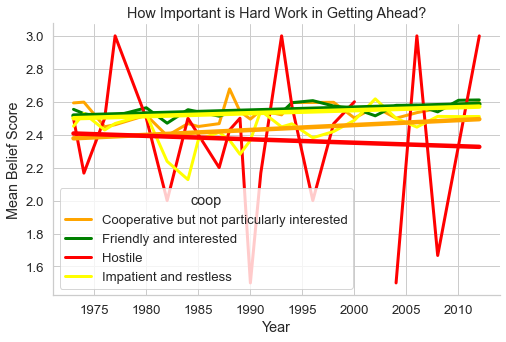

In [18]:
# Plot the four trend lines, specifying the colors
ax = by_year_attitude.plot(color = ['orange', 'green', 'red', 'yellow'], grid = True)

# plot the four regression lines
# Friendly
sns.regplot(x = by_year_attitude.index, y = 'Friendly and interested', data = by_year_attitude,
            scatter = False, ci = None, fit_reg = True, color = 'green')

# Cooperative
sns.regplot(x = by_year_attitude.index, y = 'Cooperative but not particularly interested', data = by_year_attitude,
            scatter = False, ci = None, fit_reg = True, color = 'yellow')

# Impatient
sns.regplot(x = by_year_attitude.index, y = 'Impatient and restless', data = by_year_attitude,
            scatter = False, ci = None, fit_reg = True, color = 'orange')

# Hostile
sns.regplot(x = by_year_attitude.index, y = 'Hostile', data = by_year_attitude,
            scatter = False, ci = None, fit_reg = True, color = 'red')

ax.set(title = 'How Important is Hard Work in Getting Ahead?', ylabel = 'Mean Belief Score', xlabel = 'Year')
ax


<AxesSubplot:title={'center':'Subgroups by Attitude: \nHard Work is Least Important in Getting Ahead'}, xlabel='Year', ylabel='Proportion of Respondents in Attitude Subgroup'>

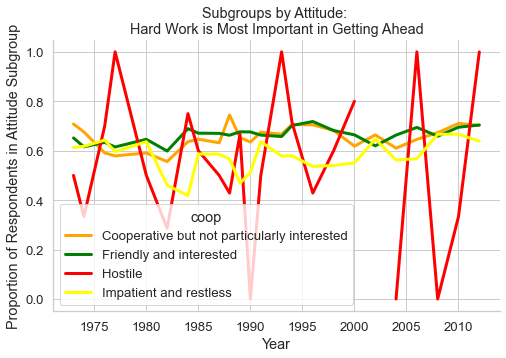

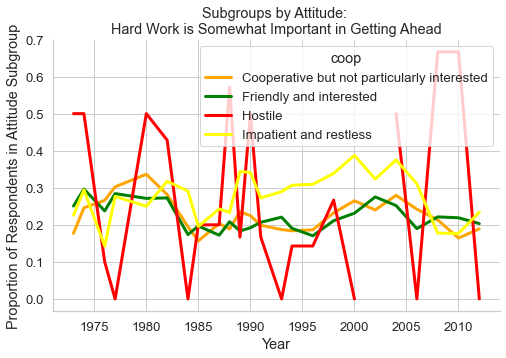

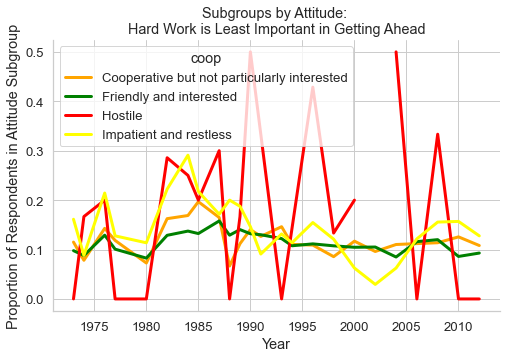

In [19]:
######################### Subgroup 1
# What percentage within each attitude group thinks that hard work is most important in getting ahead?
# Create new variable 'hardwork_most' as an indicator variable for when getahead == 3. np.where()
data['hardwork_most'] = np.where((data.getahead == 3), 1, 0)

by_year_attitude_hardwork_most = data.groupby(['year', 'coop']).mean()['hardwork_most'].unstack()
ax1 = by_year_attitude_hardwork_most.plot(color = ['orange', 'green', 'red', 'yellow'], grid = True)
ax1.set(title = 'Subgroups by Attitude: \nHard Work is Most Important in Getting Ahead', 
       ylabel = 'Proportion of Respondents in Attitude Subgroup', xlabel = 'Year')
ax1

######################### Subgroup 2
# What percentage within each attitude group thinks that hard work is somewhat important in getting ahead?
# Create new variable 'hardwork_most' as an indicator variable for when getahead == 2. np.where()
data['hardwork_somewhat'] = np.where((data.getahead == 2), 1, 0)

by_year_attitude_hardwork_somewhat = data.groupby(['year', 'coop']).mean()['hardwork_somewhat'].unstack()
ax2 = by_year_attitude_hardwork_somewhat.plot(color = ['orange', 'green', 'red', 'yellow'], grid = True)
ax2.set(title = 'Subgroups by Attitude: \nHard Work is Somewhat Important in Getting Ahead', 
       ylabel = 'Proportion of Respondents in Attitude Subgroup', xlabel = 'Year')
ax2

######################### Subgroup 3
# What percentage within each attitude group thinks that hard work is least important in getting ahead?
# Create new variable 'hardwork_most' as an indicator variable for when getahead == 1. np.where()
data['hardwork_least'] = np.where((data.getahead == 1), 1, 0)

by_year_attitude_hardwork_least = data.groupby(['year', 'coop']).mean()['hardwork_least'].unstack()
ax3 = by_year_attitude_hardwork_least.plot(color = ['orange', 'green', 'red', 'yellow'], grid = True)
ax3.set(title = 'Subgroups by Attitude: \nHard Work is Least Important in Getting Ahead', 
       ylabel = 'Proportion of Respondents in Attitude Subgroup', xlabel = 'Year')
ax3


## 3B. Gender

In [20]:
# Gender
# map the indicators variables for sex to 'Male' and 'Female'
data['sex'].replace({1: 'Male', 2: 'Female'}, inplace = True)

# get mean of 'getahead' by year and sex, present it in the form of a pivot table for easier plotting
by_year_sex = data.groupby(['year', 'sex']).mean()['getahead'].unstack()
by_year_sex.head()


sex,Female,Male
year,,
1973,2.572704,2.539941
1974,2.575641,2.487256
1976,2.565594,2.408815
1977,2.550122,2.453079
1980,2.580928,2.521809


[Text(0.5, 1.0, 'What is Most Important in Getting Ahead?'),
 Text(0, 0.5, 'Mean Belief Score'),
 Text(0.5, 0, 'Year')]

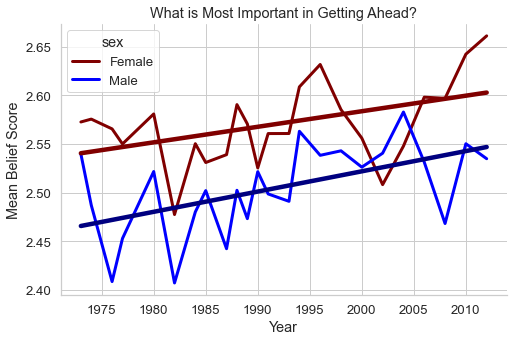

In [21]:
# Plot the two trend lines, specifying the colors
ax = by_year_sex.plot(color = ['maroon', 'blue'], grid = True)

# plot the two regression lines- one for female one for male
sns.regplot(x = by_year_sex.index, y = 'Female', data = by_year_sex,
            scatter = False, ci = None, fit_reg = True, color = 'maroon')

sns.regplot(x = by_year_sex.index, y = 'Male', data = by_year_sex,
            scatter = False, ci = None, fit_reg = True, color = 'navy')

ax.set(title = 'What is Most Important in Getting Ahead?', ylabel = 'Mean Belief Score', xlabel = 'Year')


<AxesSubplot:title={'center':'Subgroups by Gender: \nHard Work is Least Important in Getting Ahead'}, xlabel='Year', ylabel='Proportion of Respondents in Gender Subgroup'>

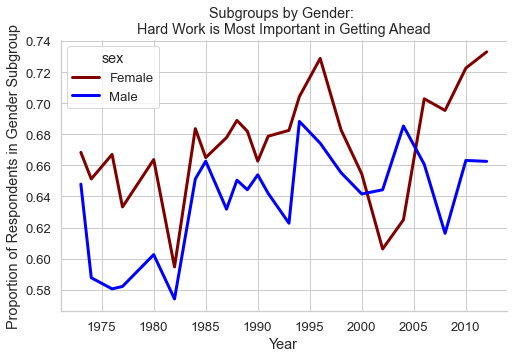

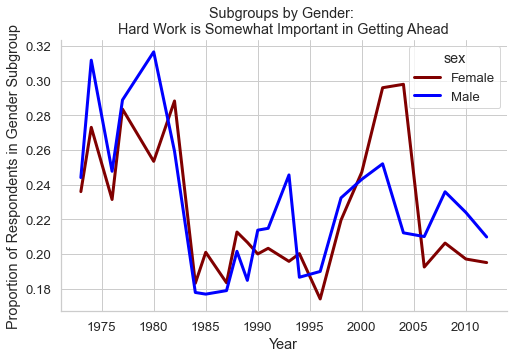

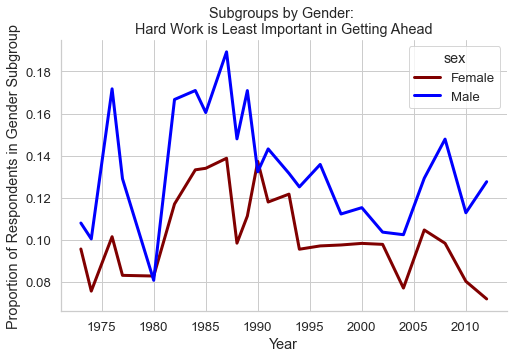

In [22]:
######################### Subgroup 1
# What percentage within each gender group thinks that hard work is most important in getting ahead?
by_year_sex_hardwork_most = data.groupby(['year', 'sex']).mean()['hardwork_most'].unstack()
ax1 = by_year_sex_hardwork_most.plot(color = ['maroon', 'blue'], grid = True)
ax1.set(title = 'Subgroups by Gender: \nHard Work is Most Important in Getting Ahead', 
       ylabel = 'Proportion of Respondents in Gender Subgroup', xlabel = 'Year')
ax1

######################### Subgroup 2
# What percentage within each gender group thinks that hard work is somewhat important in getting ahead?
by_year_sex_hardwork_somewhat = data.groupby(['year', 'sex']).mean()['hardwork_somewhat'].unstack()
ax2 = by_year_sex_hardwork_somewhat.plot(color = ['maroon', 'blue'], grid = True)
ax2.set(title = 'Subgroups by Gender: \nHard Work is Somewhat Important in Getting Ahead', 
       ylabel = 'Proportion of Respondents in Gender Subgroup', xlabel = 'Year')
ax2

######################### Subgroup 3
# What percentage within each gender group thinks that hard work is least important in getting ahead?
by_year_sex_hardwork_least = data.groupby(['year', 'sex']).mean()['hardwork_least'].unstack()
ax3 = by_year_sex_hardwork_least.plot(color = ['maroon', 'blue'], grid = True)
ax3.set(title = 'Subgroups by Gender: \nHard Work is Least Important in Getting Ahead', 
       ylabel = 'Proportion of Respondents in Gender Subgroup', xlabel = 'Year')
ax3


## Subgroup Variation Across Time Plot Findings
- I thought it might be interesting to use survey respondents' attitudes toward the survey, as well as their genders, as subgroups in determining how important hard work is to them in getting ahead. 
- The two variables used from the GSS here are 'coop' and 'sex'.

- The question associated with coop is "In general, what was the respondent's attitude toward the interview?"
- The responses were on a 4-point scale, decoded as below:
    - 1 Friendly and interested
    - 2 Cooperative but not particularly interested
    - 3 Impatient and restless
    - 4 Hostile
    
- The question associated with sex is to confirm each respondent's genders as male (1) or female (2).

- In this analysis I first plotted the mean beliefs by year of each of the attitude subgroups, as well as the mean beliefs by gender by year.
- Then, to dive deeper into each of the subgroups, I examined the subgroups by their belief in hard work being most important in getting ahead, with consideration of every response option.


- **Attitude toward survey: coop**
    - I isolated respondents who answered that they believed that hard work was most important in getting ahead, somewhat important in getting ahead, and least important in getting ahead. The left me with three plots, one for each set of response options. 
    - Within each of these response categories, I looked at the proportion of each attitude group that answered as such.
        - The majority of friendly and cooperative survey responders believed that hard work is most important in getting ahead, year over year. Over 60% of survey takers in these attitude groups believe this each year.
        - A sizeable proportion of impatient survey responders believe that hard work is somewhat important in getting ahead, as the percentage hovers between 30-40% most years.
        - Less than 20% of friendly and cooperative survey responders believe that hard work is least important in getting ahead, year over year. 
        - Hostile survey responders are quite volatile in their mean beliefs by year, with some years 100% believing that hard work is most important, and other years 0% believing that.

- **Gender: sex**
    - As above, I isolated respondents who answered that they believed that hard work was most important in getting ahead, somewhat important in getting ahead, and least important in getting ahead. The left me with three plots, one for each set of response options. 
    - Also as above, within each of these response categories I looked at the proportion of each gender that answered as such.
        - A high proportion of female survey respondents believe that hard work is most important in getting ahead, some years over 70%. A sizeable proportion of males believe this too, but the proportion of females is typically larger than males each year.
        - A higher proportion of male survey respondents than female respondents believe that hard work is least important in getting ahead each year.


# 3. Subgroup Variation across Time Models

## 3A. Attitude Level Toward Survey Models

In [23]:
# Create model for friendly/interested
lm_getahead_friendly = smf.ols('getahead ~ year', data = data[data.coop == 'Friendly and interested']).fit(cov_type = 'HC1')
lm_getahead_friendly.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     29.68
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           5.14e-08
Time:                        18:26:44   Log-Likelihood:                -28523.
No. Observations:               27240   AIC:                         5.705e+04
Df Residuals:                   27238   BIC:                         5.707e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2517      0.698     -1.793      0.073      -2.620       0.116
year           0.0019      0.000      5.448      0.000       0.001       0.003
==============================================================================
Omnibus:                     4345.145   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6838.279
Skew:                          -1.226   Prob(JB):                         0.00
Kurtosis:                       3.131   Cond. No.                     3.40e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Cooperative
lm_getahead_cooperative = smf.ols('getahead ~ year', data = data[data.coop == 'Cooperative but not particularly interested']).fit(cov_type = 'HC1')
lm_getahead_cooperative.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.858
Date:                Fri, 14 Oct 2022   Prob (F-statistic):            0.00885
Time:                        18:26:44   Log-Likelihood:                -6335.0
No. Observations:                5958   AIC:                         1.267e+04
Df Residuals:                    5956   BIC:                         1.269e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7658      1.642     -1.075      0.282      -4.984       1.453
year           0.0022      0.001      2.619      0.009       0.001       0.004
==============================================================================
Omnibus:                      895.685   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1372.950
Skew:                          -1.176   Prob(JB):                    7.37e-299
Kurtosis:                       2.986   Cond. No.                     3.64e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Impatient
lm_getahead_impatient = smf.ols('getahead ~ year', data = data[data.coop == 'Impatient and restless']).fit(cov_type = 'HC1')
lm_getahead_impatient.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.011
Date:                Fri, 14 Oct 2022   Prob (F-statistic):             0.0829
Time:                        18:26:44   Log-Likelihood:                -1387.8
No. Observations:                1259   AIC:                             2780.
Df Residuals:                    1257   BIC:                             2790.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3995      3.935     -1.118      0.264     -12.112       3.313
year           0.0034      0.002      1.735      0.083      -0.000       0.007
==============================================================================
Omnibus:                      168.276   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.117
Skew:                          -0.848   Prob(JB):                     2.56e-38
Kurtosis:                       2.348   Cond. No.                     3.79e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Hostile
lm_getahead_hostile = smf.ols('getahead ~ year', data = data[data.coop == 'Hostile']).fit(cov_type = 'HC1')
lm_getahead_hostile.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1116
Date:                Fri, 14 Oct 2022   Prob (F-statistic):              0.739
Time:                        18:26:44   Log-Likelihood:                -149.58
No. Observations:                 129   AIC:                             303.2
Df Residuals:                     127   BIC:                             308.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5375     11.772     -0.131      0.896     -24.611      21.536
year           0.0020      0.006      0.334      0.738      -0.010       0.014
==============================================================================
Omnibus:                       22.966   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.140
Skew:                          -0.813   Prob(JB):                     0.000115
Kurtosis:                       2.144   Cond. No.                     3.75e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3B. Gender Models

In [27]:
# Male
lm_getahead_male = smf.ols('getahead ~ year', data = data[data.sex == 'Male']).fit(cov_type = 'HC1')
lm_getahead_male.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.91
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           2.33e-05
Time:                        18:26:44   Log-Likelihood:                -16627.
No. Observations:               15262   AIC:                         3.326e+04
Df Residuals:                   15260   BIC:                         3.327e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6633      0.985     -1.689      0.091      -3.594       0.267
year           0.0021      0.000      4.232      0.000       0.001       0.003
==============================================================================
Omnibus:                     2111.425   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3083.336
Skew:                          -1.095   Prob(JB):                         0.00
Kurtosis:                       2.764   Cond. No.                     3.42e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Female
lm_getahead_female = smf.ols('getahead ~ year', data = data[data.sex == 'Female']).fit(cov_type = 'HC1')
lm_getahead_female.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     20.15
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           7.19e-06
Time:                        18:26:44   Log-Likelihood:                -19717.
No. Observations:               19324   AIC:                         3.944e+04
Df Residuals:                   19322   BIC:                         3.945e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1061      0.820     -1.350      0.177      -2.712       0.500
year           0.0018      0.000      4.489      0.000       0.001       0.003
==============================================================================
Omnibus:                     3350.040   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5418.851
Skew:                          -1.286   Prob(JB):                         0.00
Kurtosis:                       3.332   Cond. No.                     3.48e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Subgroup Variation Across Time Model Findings

- **Attitude toward survey: coop**
- I created a naive OLS model for each category of attitude toward survey to consider how respondents in each of those subgroups feel about hard work being most important in getting ahead. These are not interaction models as there is no interaction term; these models just aim to consider subgroups of respondents.

    - **For respondents who were friendly and interested toward the survey**, the model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0019 points (on a 3-point scale), and is statistically significant at 95% confidence due to its low p-value (p-value less than 0.05, it is 0.000).
        - The adjusted R-squared term is extremely low at 0.001, implying that we can explain about 0.1% of the variation in hard work being the most important thing in getting ahead by year for these respondents. 

    - **For respondents who were cooperative but not particularly interested toward the survey**, the model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0022 points (on a 3-point scale), and is statistically significant at 95% confidence due to its low p-value (p-value less than 0.05, it is 0.009).
        - The adjusted R-squared term is extremely low at 0.001, implying that we can explain about 0.1% of the variation in hard work being the most important thing in getting ahead by year for these respondents. 

    - **For respondents who were impatient and restless toward the survey**, the model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0034 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.083).
        - The adjusted R-squared term is slightly higher than the other models at 0.002, implying that we can explain about 0.2% of the variation in hard work being the most important thing in getting ahead by year for these respondents. 

    - **For respondents who were hostile toward the survey**, the model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0020 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.738).
        - The adjusted R-squared term is extremely low at -0.007, which implies that there is negligent explanatory power from knowing whether or not a respondent was in the hostile toward survey group.


- **Gender: sex**
- As above, I created a naive OLS model for each gender to consider how respondents in each of the genders feel about hard work being most important in getting ahead. These are not interaction models as there is no interaction term; these models just aim to consider subgroups of respondents.
    
    - **For respondents who were male**, the model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0021 points (on a 3-point scale), and is statistically significant at 95% confidence due to its low p-value (p-value less than 0.05, it is 0.000).
        - The adjusted R-squared term is extremely low at 0.001, implying that we can explain about 0.1% of the variation in hard work being the most important thing in getting ahead by year for these respondents. 

    - **For respondents who were female**, the model shows that with each year that passes, the belief that hard work is most important to getting ahead increases on average by 0.0018 points (on a 3-point scale), and is statistically significant at 95% confidence due to its low p-value (p-value less than 0.05, it is 0.000).
        - The adjusted R-squared term is extremely low at 0.001, implying that we can explain about 0.1% of the variation in hard work being the most important thing in getting ahead by year for these respondents. 
    

# Extra Credit- Interactions

## EC1. Interaction: Attitude

In [29]:
# Friendly/Interested Attitude and Belief that Hard Work is Most important
# Create indicator variable attitude
# Reference category will not show up in the results as a variable...so must be *not* friendly/interested
# Reference category is NOT friendly and interested; 
# because the variable that shows up in the table is TRUE Friendly/interested

data['friendly'] = data['coop'] == 'Friendly and interested'

# obtain results for interacted ols regression, appylying robust standard errors .fit(cov_type = 'HC1')
ols_interaction1 = smf.ols('getahead ~ year*friendly', data = data).fit(cov_type = 'HC1')
ols_interaction1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.30
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           7.34e-12
Time:                        18:26:44   Log-Likelihood:                -36417.
No. Observations:               34586   AIC:                         7.284e+04
Df Residuals:                   34582   BIC:                         7.287e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.0802      1.503     -1.384      0.166      -5.027       0.866
friendly[T.True]          0.8284      1.657      0.500      0.617      -2.420       4.077
year                      0.0023      0.001      3.056      0.002       0.001       0.004
year:friendly[T.True]    -0.0004      0.001     -0.476      0.634      -0.002       0.001
==============================================================================
Omnibus:                     5334.807   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8294.811
Skew:                          -1.199   Prob(JB):                         0.00
Kurtosis:                       3.063   Cond. No.                     1.50e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# Cooperative Attitude and Belief that Hard Work is Most important
# create indicator variable attitude
data['cooperative'] = data['coop'] == 'Cooperative but not particularly interested'

# obtain results for interacted ols regression, appylying robust standard errors .fit(cov_type = 'HC1')
ols_interaction2 = smf.ols('getahead ~ year*cooperative', data = data).fit()
ols_interaction2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.50
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           3.67e-08
Time:                        18:26:44   Log-Likelihood:                -36425.
No. Observations:               34586   AIC:                         7.286e+04
Df Residuals:                   34582   BIC:                         7.289e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.2760      0.703     -1.814      0.070      -2.654       0.102
cooperative[T.True]         -0.4898      1.787     -0.274      0.784      -3.992       3.012
year                         0.0019      0.000      5.433      0.000       0.001       0.003
year:cooperative[T.True]     0.0002      0.001      0.268      0.789      -0.002       0.002
==============================================================================
Omnibus:                     5338.241   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8302.601
Skew:                          -1.200   Prob(JB):                         0.00
Kurtosis:                       3.062   Cond. No.                     9.84e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Impatient Attitude and Belief that Hard Work is Most important
# create indicator variable attitude
data['impatient'] = data['coop'] == 'Impatient and restless'

# obtain results for interacted ols regression, appylying robust standard errors .fit(cov_type = 'HC1')
ols_interaction3 = smf.ols('getahead ~ year*impatient', data = data).fit(cov_type = 'HC1')
ols_interaction3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     23.90
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.91e-15
Time:                        18:26:44   Log-Likelihood:                -36406.
No. Observations:               34586   AIC:                         7.282e+04
Df Residuals:                   34582   BIC:                         7.285e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.3246      0.641     -2.065      0.039      -2.582      -0.068
impatient[T.True]         -3.0749      3.984     -0.772      0.440     -10.884       4.734
year                       0.0019      0.000      6.037      0.000       0.001       0.003
year:impatient[T.True]     0.0015      0.002      0.741      0.459      -0.002       0.005
==============================================================================
Omnibus:                     5337.478   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8299.958
Skew:                          -1.199   Prob(JB):                         0.00
Kurtosis:                       3.067   Cond. No.                     2.02e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# Hostile Attitude and Belief that Hard Work is Most important
# create indicator variable attitude
data['hostile'] = data['coop'] == 'Hostile'

# obtain results for interacted ols regression, appylying robust standard errors .fit(cov_type = 'HC1')
ols_interaction4 = smf.ols('getahead ~ year*hostile', data = data).fit(cov_type = 'HC1')
ols_interaction4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.01
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           3.98e-09
Time:                        18:26:44   Log-Likelihood:                -36423.
No. Observations:               34586   AIC:                         7.285e+04
Df Residuals:                   34582   BIC:                         7.289e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.3221      0.634     -2.085      0.037      -2.565      -0.079
hostile[T.True]         -0.2154     11.698     -0.018      0.985     -23.144      22.713
year                     0.0019      0.000      6.097      0.000       0.001       0.003
year:hostile[T.True]  3.572e-05      0.006      0.006      0.995      -0.011       0.012
==============================================================================
Omnibus:                     5337.293   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8300.465
Skew:                          -1.200   Prob(JB):                         0.00
Kurtosis:                       3.062   Cond. No.                     6.16e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## EC2. Interaction: Gender

In [33]:
# Male gender and Belief that Hard Work is Most important
# create indicator variable gender
data['male'] = data['sex'] == 'Male'

# obtain results for interacted ols regression, appylying robust standard errors .fit(cov_type = 'HC1')
ols_interaction5 = smf.ols('getahead ~ year*male', data = data).fit(cov_type = 'HC1')
ols_interaction5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     39.59
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.56e-25
Time:                        18:26:44   Log-Likelihood:                -36385.
No. Observations:               34586   AIC:                         7.278e+04
Df Residuals:                   34582   BIC:                         7.281e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.1061      0.820     -1.350      0.177      -2.712       0.500
male[T.True]         -0.5572      1.281     -0.435      0.664      -3.069       1.954
year                  0.0018      0.000      4.489      0.000       0.001       0.003
year:male[T.True]     0.0002      0.001      0.382      0.703      -0.001       0.002
==============================================================================
Omnibus:                     5301.800   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8222.929
Skew:                          -1.194   Prob(JB):                         0.00
Kurtosis:                       3.057   Cond. No.                     8.65e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 8.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Female gender and Belief that Hard Work is Most important
# create indicator variable gender
data['female'] = data['sex'] == 'Female'

# obtain results for interacted ols regression, appylying robust standard errors .fit(cov_type = 'HC1')
ols_interaction6 = smf.ols('getahead ~ year*female', data = data).fit(cov_type = 'HC1')
ols_interaction6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               getahead   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     39.59
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.56e-25
Time:                        18:26:44   Log-Likelihood:                -36385.
No. Observations:               34586   AIC:                         7.278e+04
Df Residuals:                   34582   BIC:                         7.281e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.6633      0.985     -1.689      0.091      -3.594       0.267
female[T.True]          0.5572      1.281      0.435      0.664      -1.954       3.069
year                    0.0021      0.000      4.232      0.000       0.001       0.003
year:female[T.True]    -0.0002      0.001     -0.382      0.703      -0.002       0.001
==============================================================================
Omnibus:                     5301.800   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8222.929
Skew:                          -1.194   Prob(JB):                         0.00
Kurtosis:                       3.057   Cond. No.                     9.54e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 9.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Attitude Interaction Findings

**Interaction of being friendly and interested toward the survey and the belief that hard work is most important in getting ahead**
- A dummy variable was created to denote a respondent as being friendly and interested toward the survey, vs. not friendly and interested toward the survey, with the reference category being not friendly and interested toward the survey. 
- The interaction term in the regression is the variable called **year:friendly[T.True]**
- The model shows that for each year that passes, for those who were friendly and interested toward the survey (compared to those who were not friendly and interested toward the survey), the belief that hard work is most important to getting ahead decreases on average by 0.0004 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.634).
- The adjusted R-squared term is low and on par with the previous models at 0.001, implying that we can explain about 0.1% of the variation in the belief that hard work is the most important thing in getting ahead if we consider whether or not someone was friendly and interested toward the survey.


**Interaction of being cooperative but not particularly interested toward the survey and the belief that hard work is most important in getting ahead**
- A dummy variable was created to denote a respondent as being cooperative (but not particularly interested) toward the survey, vs. not cooperative (and not particularly interested) toward the survey, with the reference category being not cooperative (and not particularly interested) toward the survey. 
- The interaction term in the regression is the variable called **year:cooperative[T.True]**
- The model shows that for each year that passes, for those who were cooperative (but not particularly interested)  toward the survey (compared to those who were not cooperative (and not particularly interested) toward the survey), the belief that hard work is most important to getting ahead increases on average by 0.0002 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.789).
- The adjusted R-squared term is low and on par with the previous models at 0.001, implying that we can explain about 0.1% of the variation in the belief that hard work is the most important thing in getting ahead if we consider whether or not someone was cooperative (but not particularly interested) toward the survey.


**Interaction of being impatient and restless toward the survey and the belief that hard work is most important in getting ahead**
- A dummy variable was created to denote a respondent as being impatient and restless toward the survey, vs. not impatient and restless toward the survey, with the reference category being not impatient and restless toward the survey. 
- The interaction term in the regression is the variable called **year:impatient[T.True]**
- The model shows that for each year that passes, for those who were impatient and restless toward the survey (compared to those who were not impatient and restless) toward the survey), the belief that hard work is most important to getting ahead increases on average by 0.0015 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.459).
- The adjusted R-squared term is low but better than the previous models at 0.002, implying that we can explain about 0.2% of the variation in the belief that hard work is the most important thing in getting ahead if we consider whether or not someone was impatient and restless toward the survey.


**Interaction of being hostile toward the survey and the belief that hard work is most important in getting ahead**
- A dummy variable was created to denote a respondent as being hostile toward the survey, vs. not hostile toward the survey, with the reference category being not hostile toward the survey. 
- The interaction term in the regression is the variable called **year:hostile[T.True]**
- The model shows that with each year that passes, for those who were hostile toward the survey (compared to those who were not hostile toward the survey), the belief that hard work is most important to getting ahead increases on average by 3.572e-05 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.995).
- The adjusted R-squared term is low and on par with the previous models at 0.001, implying that we can explain about 0.1% of the variation in the belief that hard work is the most important thing in getting ahead if we consider whether or not someone was hostile toward the survey.


## Gender Interaction Findings
**Interaction of being a male and the belief that hard work is most important in getting ahead**
- A dummy variable was created to denote a respondent as being male, vs. not being male, with the reference category being not male. 
- The interaction term in the regression is the variable called **year:male[T.True]**
- The model shows that with each year that passes, for those who were male (compared to those who were not male), the belief that hard work is most important to getting ahead increases on average by 0.0002 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.703).
- The adjusted R-squared term is low but better than the previous models at 0.003, implying that we can explain about 0.3% of the variation in the belief that hard work is the most important thing in getting ahead if we consider whether or not someone was male.


**Interaction of being a female and the belief that hard work is most important in getting ahead**
- A dummy variable was created to denote a respondent as being female, vs. not being female, with the reference category being not female. 
- The interaction term in the regression is the variable called **year:female[T.True]**
- The model shows that with each year that passes, for those who were female (compared to those who were not female), the belief that hard work is most important to getting ahead decreases on average by 0.0002 points (on a 3-point scale), and is not statistically significant at 95% confidence due to its high p-value (p-value greater than 0.05, it is 0.706).
- The adjusted R-squared term is low but better than the previous models at 0.003, implying that we can explain about 0.3% of the variation in the belief that hard work is the most important thing in getting ahead if we consider whether or not someone was female.